# HGCAL FE studies

### imports and initial setup

In [1]:
#imports and setup

%matplotlib inline
%cd /home/naodell/work/hgcal

import pickle
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

#from descartes import PolygonPatch
from tqdm import tqdm_notebook

from skhep.modeling import bayesian_blocks
import scripts.helpers as hlp
import scripts.readout_algorithms as algos

import matplotlib
matplotlib.rcParams.update({'font.size': 16})

/home/naodell/work/hgcal


### get the data mixtures

In the script `**.py`, I make mixtures of signal and pileup samples.  

In [25]:
gen_list = []
df_list = []
inputdir = 'data/mc_mixtures/single_electron_pt35_skim'
for filename in os.listdir(inputdir):
    data_file = open(f'{inputdir}/{filename}', 'rb')
    gen_list.extend(pickle.load(data_file))
    df_list.extend(pickle.load(data_file))
    data_file.close()
    break

algo_list = [ 'baseline', 'threshold_1bx_esort',  'threshold_8bx_esort', 'threshold_1bx_nosort', 'threshold_8bx_nosort']
mippt_scan = np.arange(1, 10, 1.)
ratios = {n:{mippt:[] for mippt in mippt_scan} for n in algo_list}
columns = ['reco_e', 'sim_e', 'pt']
cell_labels = ['zside', 'layer', 'sector', 'panel']
data_iter = list(zip(gen_list, df_list))
for gpart, data in tqdm_notebook(data_iter, total=len(data_iter)):
    gen1 = gpart.iloc[0]
    gen2 = gpart.iloc[1]
    denom = gen1.pt
    
    for mippt in mippt_scan:
        df = data.query(f'mip_pt > {mippt}')
        
        # carry out baseline selection
        df_baseline = df.query('sim_e > 0').groupby('zside')['pt'].sum() 
        r = df_baseline/denom
        ratios['baseline'][mippt].append(r.values)

        df = df.reset_index(drop=True)
        df_num = algos.threshold_algos(df, sort_by='reco_e', name='threshold_1bx_esort', ascending=False, nbx=1)
        r = df_num.query('sim_e > 0 and threshold_1bx_esort').groupby('zside')['pt'].sum()/denom
        ratios['threshold_1bx_esort'][mippt].append(r.values) 
        
        df = df.reset_index(drop=True)
        df_num = algos.threshold_algos(df, sort_by='reco_e', name='threshold_8bx_esort', ascending=False, nbx=8)
        r = df_num.query('sim_e > 0 and threshold_8bx_esort').groupby('zside')['pt'].sum()/denom
        ratios['threshold_8bx_esort'][mippt].append(r.values) 
        
        df = df.reset_index(drop=True)
        df_num = algos.threshold_algos(df, sort_by=['ievt', 'cell'], name='threshold_1bx_nosort', ascending=True, nbx=1)
        r = df_num.query('sim_e > 0 and threshold_1bx_nosort').groupby('zside')['pt'].sum()/denom
        ratios['threshold_1bx_nosort'][mippt].append(r.values) 
        
        df = df.reset_index(drop=True)
        df_num = algos.threshold_algos(df, sort_by=['ievt', 'cell'], name='threshold_8bx_nosort', ascending=True, nbx=8)
        r = df_num.query('sim_e > 0 and threshold_8bx_nosort').groupby('zside')['pt'].sum()/denom
        ratios['threshold_8bx_nosort'][mippt].append(r.values) 
        
ratios = {a:{pt:np.concatenate(d) for pt, d in algo_data.items()} for a, algo_data in ratios.items()}

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

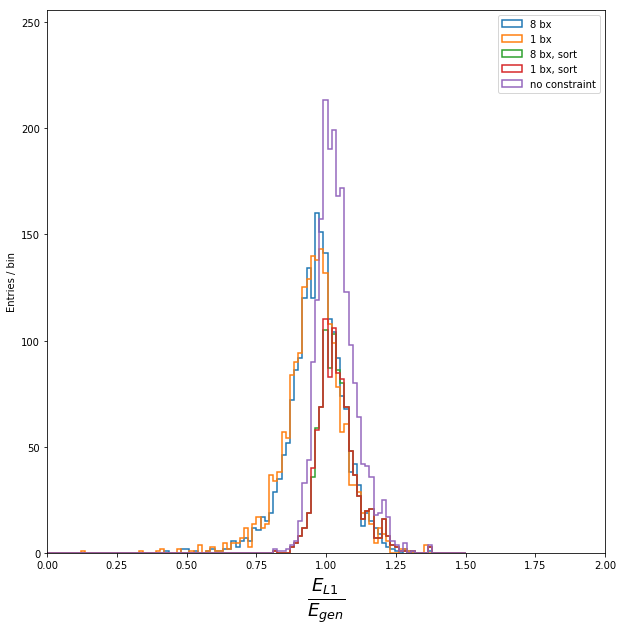

In [27]:
# mip_pt > 1 histograms
fig = plt.figure(figsize=(10, 10), facecolor='white')

ax = plt.subplot()
ax.hist(ratios['threshold_1bx_esort'][1], bins=100, range=[0, 1.5], linewidth=1.5, histtype='step')
ax.hist(ratios['threshold_8bx_esort'][1], bins=100, range=[0, 1.5], linewidth=1.5, histtype='step')
ax.hist(ratios['threshold_1bx_nosort'][1], bins=100, range=[0, 1.5], linewidth=1.5, histtype='step')
ax.hist(ratios['threshold_8bx_nosort'][1], bins=100, range=[0, 1.5], linewidth=1.5, histtype='step')
h, b, _ = ax.hist(ratios['baseline'][1], bins=100, range=[0, 1.5], linewidth=1.5, histtype='step')

ax.set_xlim(0, 2.)
ax.set_ylim(0, 1.2*np.max(h))
#ax.set_xlabel(r'$\frac{p_{T,L1}}{p_{T,gen}}$', fontsize=26)
ax.set_xlabel(r'$\frac{E_{L1}}{E_{gen}}$', fontsize=26)
ax.set_ylabel('Entries / bin')

labels = ['8 bx', '1 bx', '8 bx, sort', '1 bx, sort', 'no constraint']
#labels = ['8 bx, sort', '1 bx, sort', 'no constraint']
ax.legend(labels)

plt.savefig('plots/threshold_algo_resolution_e35.pdf')
plt.show()

In [ ]:
# mip_pt resolution scans
